# generating embeddings with model trained with cls-pooling vs Xpressor layers

In [ ]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from scprint import scPrint
from scprint.tasks import GeneEmbeddingExtractor
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download

from scipy.stats import spearmanr
from anndata import AnnData

from grnndata.utils import TF, file_dir
import gseapy as gp

%load_ext autoreload
%autoreload 2

import torch

torch.set_float32_matmul_precision("medium")


LOC = "../..data/temp/"  #

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


→ connected lamindb: jkobject/scprint_v2


In [28]:
adata = sc.read(
    LOC + "glio_smart_highdepth" + ".h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",
)

max_len = 4000 if adata.X.sum(1).mean() < 10_000 else 8000
preprocessor = Preprocessor(
    force_preprocess=True,
    skip_validate=True,
    # drop_non_primary=False,
    do_postp=False,
)
print("")
print(adata.X.sum(1).mean())
adata = preprocessor(adata)


388362.5
Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 3589 renamining
filtered out 22 cells, 3567 renamining
Removed 7 genes not known to the ontology
Removed 0 duplicate genes
Added 48469 genes in the ontology but not present in the dataset
starting QC
Seeing 71 outliers (1.99% of total dataset):
done
AnnData object with n_obs × n_vars = 3567 × 70611
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping_cluster', 'Cluster_2d', 'Cluster_2d_color', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self

In [ ]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../../../w937u4o1.ckpt"
# model_checkpoint_file = "../../../psqzicou.ckpt"
# w937u4o1

In [44]:
m = torch.load(model_checkpoint_file, map_location="cpu")

In [11]:
m["hyper_parameters"].keys()

dict_keys(['d_model', 'nhead', 'nlayers', 'memmap_gene_emb', 'finetune_gene_emb', 'freeze_embeddings', 'normalization', 'attn_bias', 'expr_encoder_layers', 'transformer', 'expr_emb_style', 'n_input_bins', 'mvc_decoder', 'pred_embedding', 'label_counts', 'layers_cls', 'compress_class_dim', 'cell_specific_blocks', 'zinb', 'splicing_head', 'do_adv_cls', 'dropout', 'lr', 'nb_features', 'feature_redraw_interval', 'num_heads_kv', 'd_model_cell', 'nhead_cell', 'nlayers_cell', 'num_heads_kv_cell', 'residual_in_fp32', 'checkpointing', 'fused_dropout_add_ln', 'fused_mlp', 'fused_bias_fc', 'drop_path_rate', 'precpt_gene_emb', '_instantiator', 'labels_hierarchy', 'classes', 'label_decoders', 'gene_pos_enc', 'genes', 'organisms', 'use_metacell_token'])

In [104]:
m["hyper_parameters"]["label_decoders"] = {
    k: {u: j if j is not None else "None" for u, j in v.items()}
    for k, v in m["hyper_parameters"]["label_decoders"].items()
}

In [ ]:
rn = {
    "expr_encoder.encoder.2.weight": "expr_encoder.encoder.1.weight",
    "expr_encoder.encoder.2.bias": "expr_encoder.encoder.1.bias",
    "expr_encoder.encoder.6.weight": "expr_encoder.encoder.5.weight",
    "expr_encoder.encoder.6.bias": "expr_encoder.encoder.5.bias",
    "expr_decoder.fc.2.weight": "expr_decoder.fc.1.weight",
    "expr_decoder.fc.2.bias": "expr_decoder.fc.1.bias",
    "expr_decoder.fc.6.weight": "expr_decoder.fc.5.weight",
    "expr_decoder.fc.6.bias": "expr_decoder.fc.5.bias",
}
m["state_dict"] = {k if k not in rn else rn[k]: v for k, v in m["state_dict"].items()}

In [20]:
m["hyper_parameters"].pop("checkpointing")

False

In [74]:
m["hyper_parameters"].pop("residual_in_fp32")
m["hyper_parameters"].pop("fused_dropout_add_ln")
m["hyper_parameters"].pop("checkpointing")
m["hyper_parameters"].pop("fused_mlp")
m["hyper_parameters"].pop("fused_bias_fc")
m["hyper_parameters"].pop("drop_path_rate")

0.0

In [23]:
m["hyper_parameters"].pop("class_compression")
m["hyper_parameters"].pop("depth_atinput")
m["hyper_parameters"].pop("cell_transformer_layers")
m["hyper_parameters"].pop("residual_in_fp32")
m["hyper_parameters"].pop("fused_dropout_add_ln")
m["hyper_parameters"].pop("checkpointing")
m["hyper_parameters"].pop("fused_mlp")
m["hyper_parameters"].pop("fused_bias_fc")
m["hyper_parameters"].pop("drop_path_rate")

KeyError: 'class_compression'

In [75]:
torch.save(m, model_checkpoint_file)

In [76]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)

FYI: scPrint is not attached to a `Trainer`.


In [5]:
adata.obs.cell_type.value_counts()

cell_type
myeloid cell                      1842
neoplastic cell                   1079
oligodendrocyte precursor cell     406
astrocyte                           88
oligodendrocyte                     81
vascular lymphangioblast            50
neuron                              21
Name: count, dtype: int64

In [29]:
extractor = GeneEmbeddingExtractor(
    genelist=adata.var.index[
        np.array(
            (adata[adata.obs.cell_type == "neuron"].X > 0).sum(0)
            > (adata.obs.cell_type.value_counts()["neuron"] * 0.3)
        )[0]
    ].tolist(),
    batch_size=16,
    num_workers=8,
    average=False,
)

# model 1

In [78]:
model = model.to("cuda")

In [79]:
gemb_da = extractor(model, adata[adata.obs.cell_type == "neuron", :])

Using 100.00% of the genes in the gene list
not on wandb, could not set name


In [80]:
gemb_da.varm["gene_embeddings"] = gemb_da.uns["all_embeddings"][0]

In [81]:
gemb_da = gemb_da.T

In [82]:
gemb_da.obsm["gene_pca"] = sc.pp.pca(
    gemb_da.obsm["gene_embeddings"], n_comps=30, use_highly_variable=False
)

sc.pp.neighbors(
    gemb_da,
    use_rep="gene_pca",  # can be a plain NumPy / sparse array
    n_neighbors=15,
    key_added="gene_neighbors",  # keeps it separate from the cell graph
)

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


In [83]:
sc.tl.umap(
    gemb_da,
    neighbors_key="gene_neighbors",  # tells Scanpy which graph to use
    init_pos="spectral",
    random_state=0,
    min_dist=0.3,
)

In [100]:
model

scPrint(
  (gene_encoder): Sequential(
    (0): GeneEncoder(
      (embeddings): Embedding(335182, 512)
    )
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=512, bias=True)
      (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (6): ReLU()
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (pos_encoder): PositionalEncoding()
  (class_encoder): CategoryValueEncoder(
    (embedding): Embedding(10, 256)
  )
  (metacell_encoder): CategoryValueEncoder(
    (embedding): Embedding(2, 512)
  )
  (transformer): FlashTrans

In [84]:
genes = load_genes(["NCBITaxon:9606"])

In [85]:
gemb_da.obs = genes.loc[gemb_da.obs.index]

In [86]:
gemb_da.obs["expression"] = np.log(1 + gemb_da.X[:, 0])
gemb_da.obs["zero_expression"] = gemb_da.X[:, 0] == 0

In [88]:
sc.tl.leiden(
    gemb_da,
    neighbors_key="gene_neighbors",
    resolution=0.5,
    key_added="leiden",
    flavor="igraph",
    random_state=42,
)  # use weights to get more clusters

... storing 'biotype' as categorical
... storing 'organism' as categorical


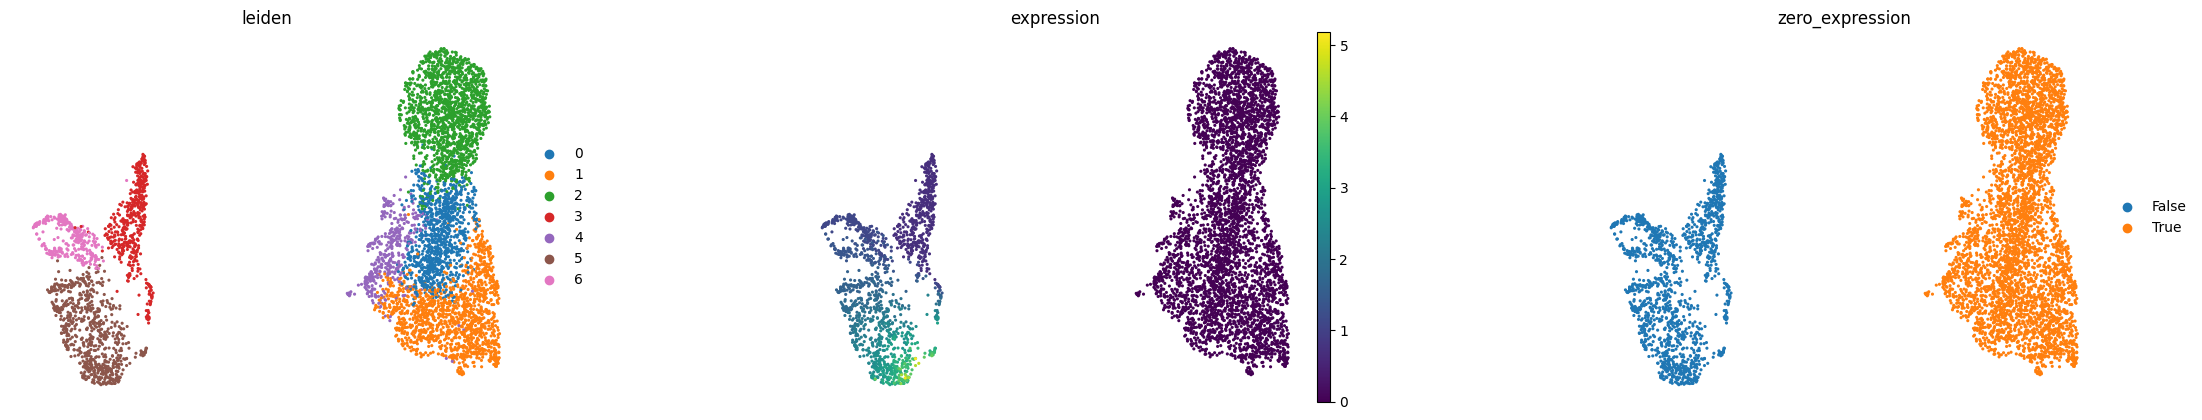

In [89]:
sc.pl.umap(
    gemb_da,
    color=["leiden", "expression", "zero_expression"],
    frameon=False,
    wspace=0.4,
)

In [ ]:
sc.pl.umap(
    gemb_da,
    color=["leiden", "expression", "zero_expression"],
    frameon=False,
    wspace=0.4,
)  # mean of all

In [ ]:
names = gp.get_library_name()
names

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'COMPARTMENTS_Curated_2025',
 'COMPARTMENTS_Experimental_2025',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Scre

In [ ]:
sc.tl.leiden(
    gemb_da_2,
    neighbors_key="gene_neighbors",
    resolution=0.5,
    key_added="leiden",
    flavor="igraph",
    random_state=42,
)  # use weights to get more clusters

In [ ]:
# lots of PPI hub and chromosome location, mircro<RNA, TF chip-seq 2 GO MF, 1 GO CC Nucleus

In [ ]:
gene_sets = [
    # "KEGG_2021_Human",
    # "ENCODE_TF_ChIP-seq_2015",
    # "GO_Molecular_Function_2025",
    # {"TFs": TF},
    # file_dir + "/celltype.gmt",
    # "OMIM_Disease",
    # "WikiPathways_2024_Human",
    # "GO_Cellular_Component_2025",
    # "GTEx_Tissues_V8_2023",
    # "TargetScan_microRNA",
    # "Chromosome_Location",
    # "PPI_Hub_Proteins",
]

pre_res = gp.enrich(
    gene_list=gemb_da.obs.symbol[
        gemb_da.obs["leiden"] == "5"
    ].tolist(),  # or rnk = rnk,
    gene_sets=gene_sets,
    background=gemb_da.obs.symbol.tolist(),  # or "hsapiens_gene_ensembl", or int, or text file  or a list of genes
    outdir=None,
    verbose=True,
)

pre_res.res2d[pre_res.res2d["Adjusted P-value"] < 0.05]

2025-08-07 14:12:33,630 [INFO] Run: OMIM_Disease 
2025-08-07 14:12:34,562 [INFO] Done.


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes


# second model without XPressor

In [31]:
model = model.to("cuda")

In [48]:
gemb_da_2 = extractor(model, adata[adata.obs.cell_type == "neuron", :])

Using 100.00% of the genes in the gene list
not on wandb, could not set name


In [51]:
gemb_da_2.varm["gene_embeddings"] = gemb_da_2.uns["all_embeddings"].mean(0)

In [52]:
gemb_da_2 = gemb_da_2.T

In [53]:
gemb_da_2.obsm["gene_pca"] = sc.pp.pca(
    gemb_da_2.obsm["gene_embeddings"], n_comps=30, use_highly_variable=False
)

sc.pp.neighbors(
    gemb_da_2,
    use_rep="gene_pca",  # can be a plain NumPy / sparse array
    n_neighbors=15,
    key_added="gene_neighbors",  # keeps it separate from the cell graph
)

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


In [54]:
sc.tl.umap(
    gemb_da_2,
    neighbors_key="gene_neighbors",  # tells Scanpy which graph to use
    init_pos="spectral",
    random_state=0,
    min_dist=0.3,
)

In [37]:
model

scPrint(
  (gene_encoder): GeneEncoder(
    (embeddings): Embedding(44720, 256)
  )
  (expr_encoder): ContinuousValueEncoder(
    (encoder): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (6): ReLU()
      (7): Dropout(p=0.1, inplace=False)
      (8): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (pos_encoder): PositionalEncoding()
  (class_encoder): CategoryValueEncoder(
    (embedding): Embedding(8, 256)
  )
  (transformer): FlashTransformer(
    (blocks): ModuleList(
      (0-7): 8 x Block(
        (mixer): MHA(
          (Wqkv): Linear(in_features=256, out_features=768, bias=True)
          (inner_attn): FlashSelfAttention()
          (inner_cross_attn): FlashCrossAttention(
       

In [38]:
genes = load_genes(["NCBITaxon:9606"])

In [55]:
gemb_da_2.obs = genes.loc[gemb_da_2.obs.index]

In [56]:
gemb_da_2.obs["expression"] = np.log(1 + gemb_da_2.X[:, 0])
gemb_da_2.obs["zero_expression"] = gemb_da_2.X[:, 0] == 0

In [ ]:
sc.tl.leiden(
    gemb_da_2,
    neighbors_key="gene_neighbors",
    resolution=0.5,
    key_added="leiden",
    flavor="igraph",
    random_state=42,
)  # use weights to get more clusters

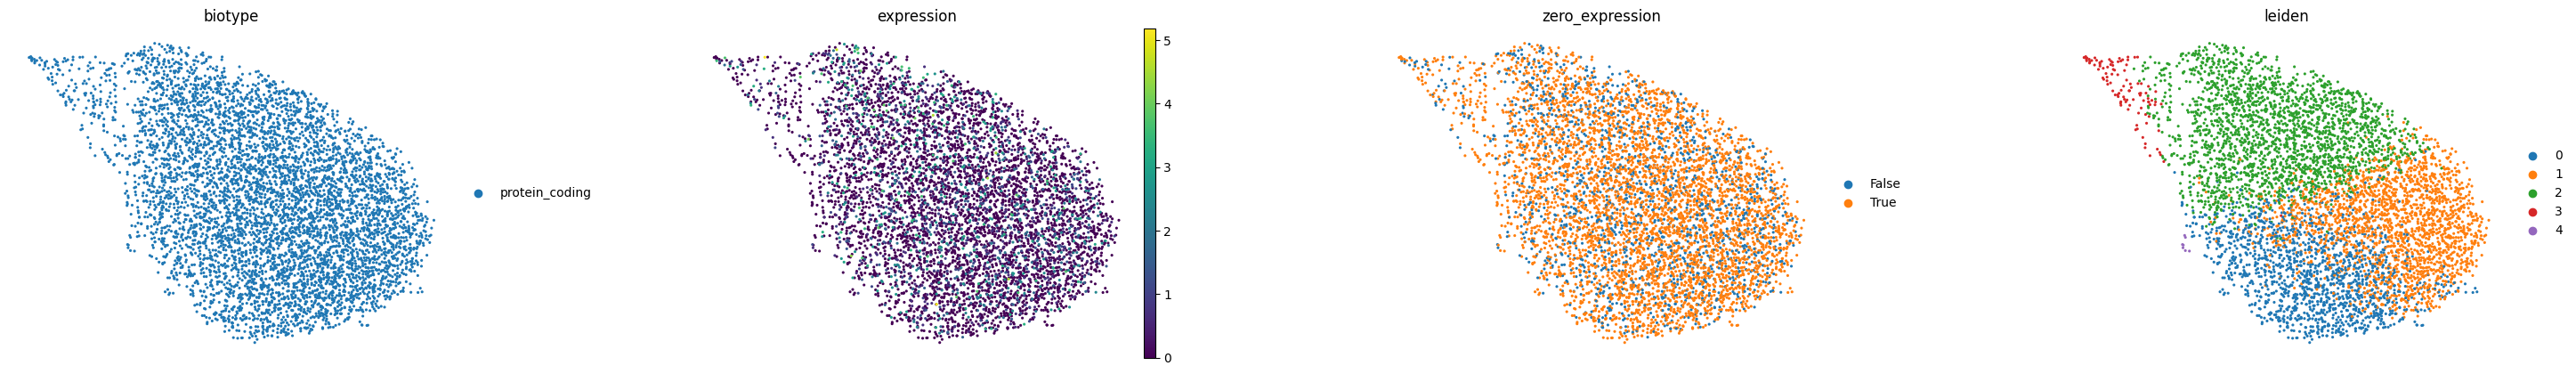

In [ ]:
sc.pl.umap(
    gemb_da_2,
    color=["leiden", "expression", "zero_expression"],
    frameon=False,
    wspace=0.4,
)  # mean of all

0 go MF, 0 CC, 0 TF chip seq...


In [ ]:
gene_sets = [
    # "KEGG_2021_Human",
    # "ENCODE_TF_ChIP-seq_2015",
    # "GO_Molecular_Function_2025",
    # {"TFs": TF},
    # file_dir + "/celltype.gmt",
    # "OMIM_Disease",
    # "WikiPathways_2024_Human",
    # "GO_Cellular_Component_2025",
    # "GTEx_Tissues_V8_2023",
    # "TargetScan_microRNA",
    # "Chromosome_Location",
    "PPI_Hub_Proteins",
]

pre_res = gp.enrich(
    gene_list=gemb_da_2.obs.symbol[
        gemb_da_2.obs["leiden"] == "0"
    ].tolist(),  # or rnk = rnk,
    gene_sets=gene_sets,
    background=gemb_da_2.obs.symbol.tolist(),  # or "hsapiens_gene_ensembl", or int, or text file  or a list of genes
    outdir=None,
    verbose=True,
)

pre_res.res2d[pre_res.res2d["Adjusted P-value"] < 0.05]

2025-08-07 14:13:58,084 [INFO] Run: PPI_Hub_Proteins 
2025-08-07 14:13:59,257 [INFO] Done.


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes


... storing 'biotype' as categorical
... storing 'organism' as categorical


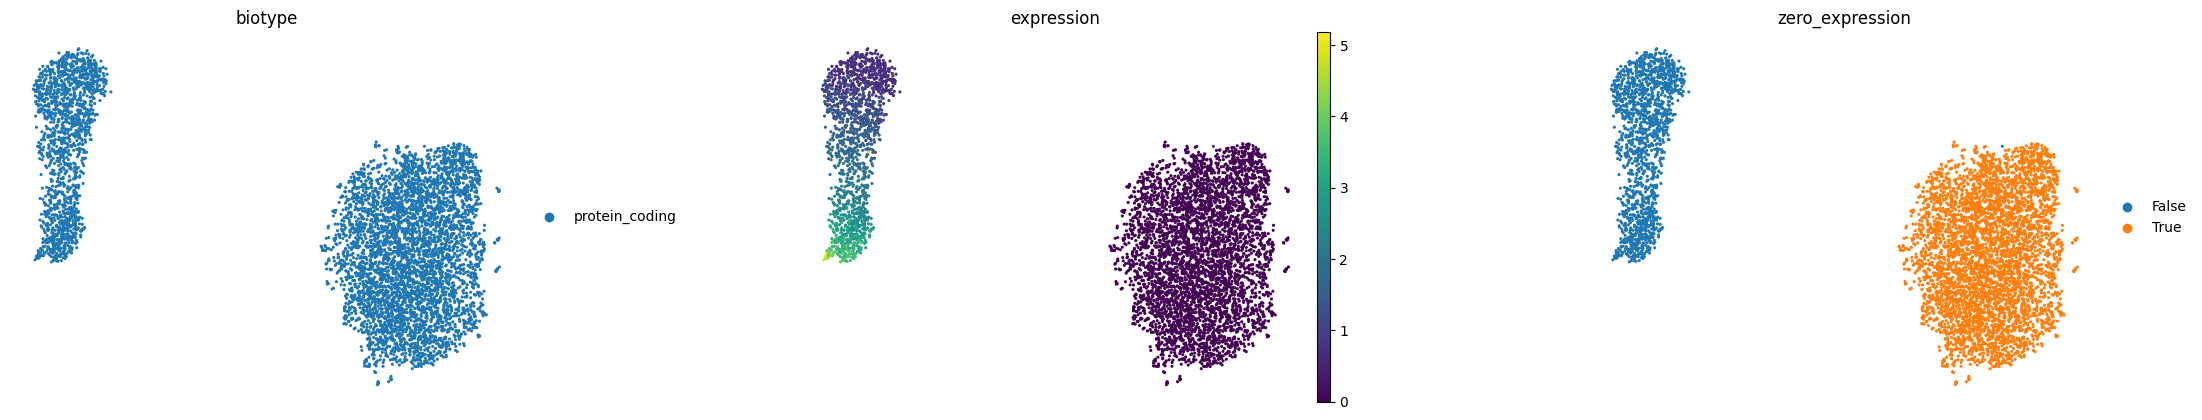

In [42]:
sc.pl.umap(
    gemb_da_2,
    color=["biotype", "expression", "zero_expression"],
    frameon=False,
    wspace=0.4,
)